In [1]:
import tensorflow_hub as hub
import tensorflow as tf
inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, output_shape=(2048,), trainable=False)
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [2]:
import pandas as pd
label_text = pd.read_csv('./Downloads/dog_data/labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [34]:
unique_Y = label_text['breed'].unique().tolist()

In [3]:
import os
import shutil

os.mkdir('./Downloads/train_sub')

for i in range(len(label_text)):
    if os.path.exists('./Downloads/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('./Downloads/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('./Downloads/dog_data/train/' + label_text.loc[i]['id'] +\
                '.jpg', './Downloads/train_sub/' + label_text.loc[i]['breed'])

In [4]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True,
                                   shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

In [14]:
train_generator = train_datagen.flow_from_directory(directory='./Downloads/train_sub/',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    seed=13,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory='./Downloads/train_sub/',
                                                    subset='validation', batch_size=1,
                                                    seed=13,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(image_size, image_size))

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


In [23]:
batch_step = (7718 * 3) // batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0:
        print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)
    
    feature = feature_model.predict(x)
    train_features.extend(feature)
    
train_features = np.array(train_features)
train_Y = np.array(train_Y)
print(train_features.shape)
print(train_Y.shape)

0
100
200
300
400
500
600
700
(23058, 2048)
(23058, 120)


In [24]:
valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0:
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)
    
    feature = feature_model.predict(x)
    valid_features.extend(feature)
    
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2504, 2048)
(2504, 120)


In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(2048,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

model.compile(tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               30840     
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(train_features, train_Y, validation_data=(valid_features, valid_Y),
                    epochs=10, batch_size=32)

Epoch 1/10
721/721 [==============================] - 5s 6ms/step - loss: 3.8261 - accuracy: 0.2399 - val_loss: 0.9128 - val_accuracy: 0.8742
Epoch 2/10
721/721 [==============================] - 5s 6ms/step - loss: 1.0991 - accuracy: 0.7587 - val_loss: 0.4174 - val_accuracy: 0.8982
Epoch 3/10
721/721 [==============================] - 4s 6ms/step - loss: 0.6606 - accuracy: 0.8215 - val_loss: 0.3403 - val_accuracy: 0.9002
Epoch 4/10
721/721 [==============================] - 4s 5ms/step - loss: 0.5246 - accuracy: 0.8449 - val_loss: 0.3220 - val_accuracy: 0.8934
Epoch 5/10
721/721 [==============================] - 4s 5ms/step - loss: 0.4551 - accuracy: 0.8648 - val_loss: 0.3117 - val_accuracy: 0.8990
Epoch 6/10
721/721 [==============================] - 4s 5ms/step - loss: 0.4163 - accuracy: 0.8707 - val_loss: 0.3018 - val_accuracy: 0.9042
Epoch 7/10
721/721 [==============================] - 4s 6ms/step - loss: 0.3744 - accuracy: 0.8831 - val_loss: 0.3067 - val_accuracy: 0.9030
Epoch 

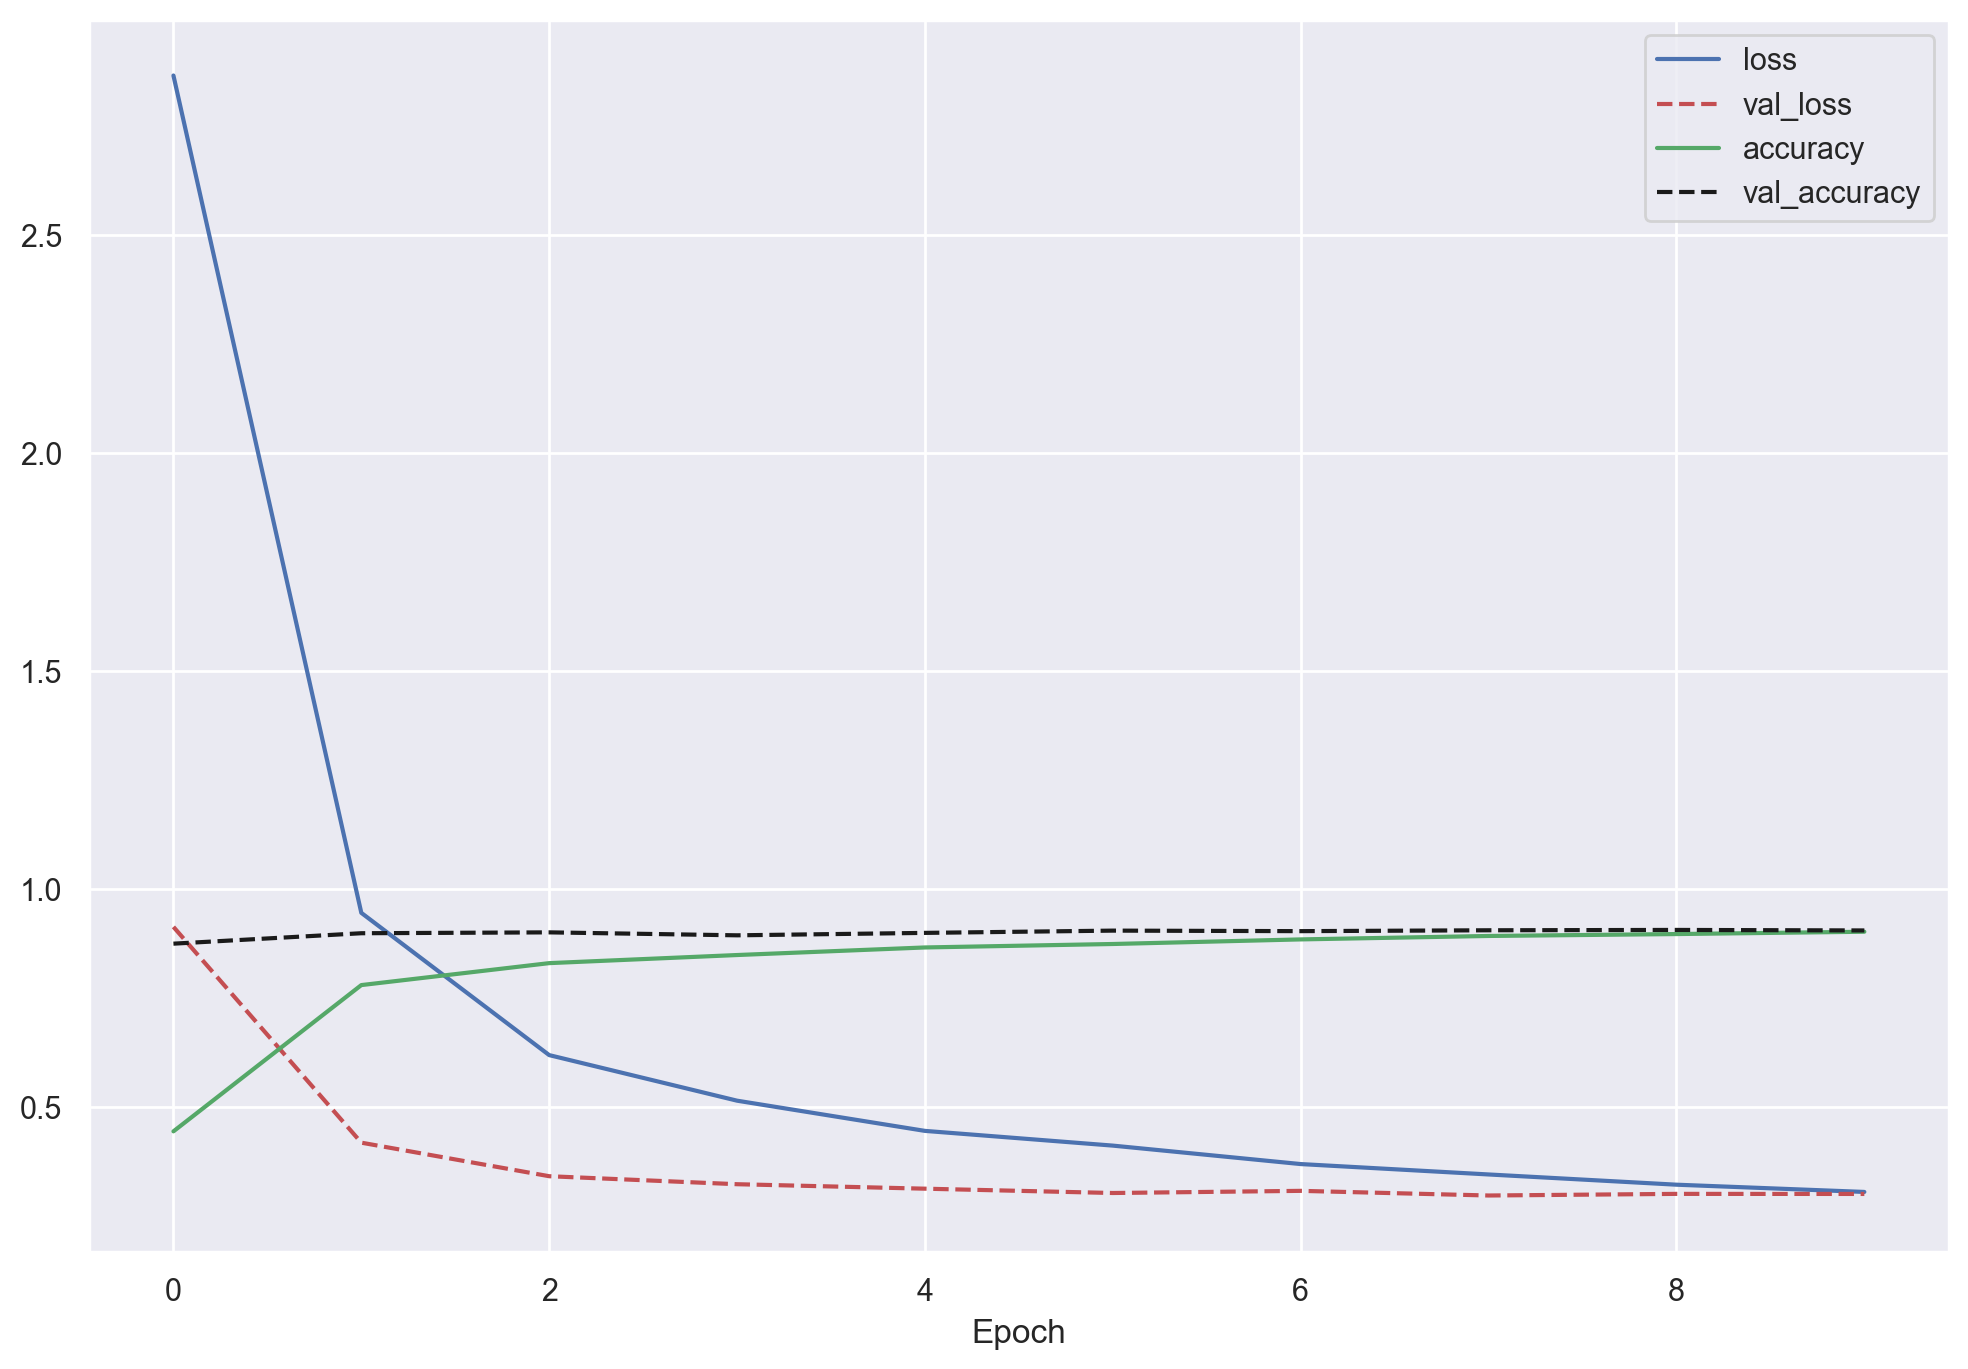

In [27]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [33]:
train_features

array([[0.15397957, 0.11341944, 0.31306005, ..., 0.9308474 , 0.31705135,
        0.01912061],
       [0.25233713, 0.5661757 , 0.03397796, ..., 0.8216865 , 1.4502958 ,
        0.4025698 ],
       [0.1861706 , 0.26547283, 0.08759589, ..., 0.89633775, 0.36336035,
        0.43754423],
       ...,
       [0.12843241, 0.5981581 , 0.19714671, ..., 0.48999605, 0.07027937,
        0.05506669],
       [0.17439012, 0.35183266, 0.05367189, ..., 0.588862  , 0.17225796,
        0.10898867],
       [0.12671746, 0.06058701, 0.02550448, ..., 0.10657009, 0.00294347,
        0.17063837]], dtype=float32)

In [35]:
unique_sorted_Y = sorted(unique_Y)
print(unique_sorted_Y)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [36]:
import random

image_path = random.choice(valid_generator.filepaths)
real_y = image_path.split('/')[2]
idx = unique_sorted_Y.index(real_y)

img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(299,299))
img = img / 255.0
img = np.expand_dims(img, axis=0)

feature_vector = feature_model.predict(img)

prediction = mopdel.predict(feature_vector)[0]

top_5_predict = prediction.argsort()[::-1][:5]
labels = [unique_sorted_Y[index] for index in top_5_predict]

ValueError: 'train_sub' is not in list

In [30]:
print(top_5_predict)
print(labels)

NameError: name 'top_5_predict' is not defined

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(plt.imread(image_path))
plt.title(real_y)
plt.axis('off')

plt.subplot(1,2,2)
color = ['gray'] * 5
if idx in top_5_predict:
    color[top_5_predict.tolist().index(idx)] = 'green'
color = color[::-1]
plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
plt.yticks(range(5), labels[::-1])
plt.show()